# Identify relationships between Prostate cancer associated SNPs and genes

In [19]:
# Load the required packages
from neo4j import GraphDatabase
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', -1)

## Setting parameters and creating connection to Neo4J

In [2]:
# Set the genomic parameters
delta_bp = 10000
FC_cutoff = 1.5
FDR_cutoff = 0.0001

In [3]:
# Setup a connection to the database
driver = GraphDatabase.driver("bolt://localhost:7687")
session =  driver.session()

## Loading and modifying the reference set

In [4]:
# Read in the data of Farashi et al. that is used as a reference set
farashi = pd.read_excel("Input sets/Farashi/41568_2018_87_MOESM1_ESM-3.xls", header = 1)

# Remove the empty rows at the bottom
farashi = farashi[farashi["SNP ID"].notnull() & farashi["Target/assigned/e-Gene"].notnull()]

### Updating gene names and SNP ID's in reference set

Not all gene names appear to be correct, and could therefore be found in PathwayStudio. These were therefore searched on https://www.ncbi.nlm.nih.gov/gene/ to identify their updated names, as described in their "Aliases" or "Also known as" names. Entries were always filtered based upon species, i.e. homo sapiens.

In [5]:
# Create separate entries for cells with delimited genes
farashi["Target/assigned/e-Gene"] = farashi["Target/assigned/e-Gene"].str.replace(", ", ";")
farashi = farashi.assign(gene=farashi["Target/assigned/e-Gene"].str.split(';')).explode('gene')

# One gene has as postfix "FoxA1 binding", which we manually remove
farashi.drop(farashi[farashi["gene"] == "FoxA1 binding"].index, inplace = True)

# Strip whitespaces
farashi["gene"] = farashi["gene"].str.strip()

# Some gene names are outdated/erroneous. These are manually mapped to correct genes as decribed above
gene_replacement_dictionary = { "MSMB1" : "MSMB",
                                "MSMB2" : "MSMB",
                                "NCOA4-1" : "NCOA4P1",
                                "NCOA4-3" : "NCOA4P3", 
                                "ANKRD5" : "ANKEF1", 
                                "C6orf228" : "SMIM13",
                                "HoxB13" : "HOXB13",
                                "LASS2" : "CERS2",
                                "C10orf32" : "BORCS7",
                                "LOC100505761" : "RPARP-AS1",
                                "LOC100505495" : "PCAT19",
                                "WDR52" : "CFAP44",
                                "HCG4P6" : "HCG4B",
                                "LOC285830" : "HLA-F-AS1",
                                "RAB7L1" : "RAB29",
                                "LOC284578" : "MFSD4A-AS1",
                                "AGAP7" : "AGAP7P",
                                "C2orf43" : "LDAH",
                                "FAM96B" : "CIAO2B",
                                "TMEM180" : "MFSD13A",
                                "WBSCR27" : "METTL27",
                                "KLK3 (PSA)" : "KLK3",
                                "PCAT1 (lncRNA)" : "PCAT1",
                                "SUV420H1" : "KMT5B",
                                "c-MYC" : "MYC"}

farashi["gene"] = farashi["gene"].replace(gene_replacement_dictionary)

In [6]:
# Replace fault-inducing postfixes for snp data
farashi["SNP ID"] = farashi["SNP ID"].str.strip()
farashi["SNP ID"].replace("(_A)|(_C)", "", regex = True, inplace = True)

# Remove entries without valid rs identifiers
farashi.drop(farashi[farashi["SNP ID"].str.startswith("chr")].index, inplace = True)

Similar to the genes, some of the SNP ID's need to be updated as well, as they have been merged with other rs identifiers

These invalid rs identifiers can be found in the next step, where dbSNP is queried.
These missing rs identifiers were subsequently queried on https://www.ncbi.nlm.nih.gov/snp/, where their updated rs identifier was retrieved.

Nonetheless, some rs identifiers could not be found on the dbsnp at all, even to map it. These were removed from the reference set.

In [7]:
# Create a mapping dictionary
snp_replacement_dictionary = {"rs565245309" : "rs10700825",
                              "rs397764955" : "rs11371876",
                              "rs567544918" : "rs143009074",
                              "rs68007409" : "rs58061354",
                              "rs576874987" : "rs2735090",
                              "rs56969947" : "rs5794883",
                              "rs71390080" : "rs35883900",
                              "rs397885676" : "rs35853071",
                              "rs563936332" : "rs11425106",
                              "rs570238728" :  "rs2735091",
                              "rs386572937" : "rs2735095",
                              "rs368454874" : "rs5875242",
                              "rs576956856" : "rs557303655",
                              "rs527768094" : "rs3115587",
                              "rs34421549" : "rs11281315",
                              "rs543833159" : "rs9261476",
                              "rs573341295" : "rs3083610",
                              "rs397841490" : "rs3839562",
                              "rs72562630" : "rs10643878",
                              "rs67276543" : "rs34884832",
                              "rs113645266" : "rs6557271",
                              "rs540840764" : "rs9278594",
                              "rs145076668" : "rs34837204",
                              "rs79588872" : "rs35538902",
                              "rs397847839" : "rs35826034",
                              "rs551993434" : "rs11371951",
                              "rs113130272" : "rs11153141",
                              "rs114376585" : "rs3096702",
                              "rs527588882" : "rs9278592",
                              "rs144721865" : "rs9368661",
                              "rs572291073" : "rs2571388",
                              "rs376201080" : "rs142474496",
                              "rs34948850" : "rs10688614",
                              "rs397887654" : "rs36076724",
                              "rs114473420" : "rs3135340",
                              "rs371043306" : "rs145380596",
                              "rs572943237" : "rs11421756",
                              "rs139078838" : "rs9501073",
                              "rs539183916" : "rs2437062",
                              "rs386410791" : "rs141020575",
                              "rs141507970" : "rs9267919",
                              "rs397823414" : "rs35850123",
                              "rs63475060" : "rs5875246",
                              "rs139104997" : "rs9261481",
                              "rs150282463" : "rs13137700",
                              "rs143466021" : "rs9269108",
                              "rs5875234" : "rs3058350"
                             }

not_found_dbsnp = {"rs77010356", "rs60284051", "rs563604877"}

# Strip whitespaces
farashi["SNP ID"] = farashi["SNP ID"].replace(snp_replacement_dictionary)

In [8]:
# Get the SNP properties from dbsnp
import myvariant
mv = myvariant.MyVariantInfo()
   
dbsnp = mv.querymany(list(set(farashi["SNP ID"])), scopes='dbsnp.rsid', fields='dbsnp', returnall = True)
print("PASSED: Only known SNPs missing") if not_found_dbsnp == set(dbsnp["missing"]) else print("ERROR: New SNPs missing")

querying 1-1000...done.
querying 1001-1139...done.
Finished.
482 input query terms found dup hits:
	[('rs3798439', 3), ('rs12653946', 2), ('rs266872', 2), ('rs6738009', 3), ('rs7481129', 2), ('rs28749
3 input query terms found no hit:
	['rs60284051', 'rs77010356', 'rs563604877']
Only known SNPs missing


In [9]:
# Merge the dbSNP data with the reference set
dbsnp_tab = pd.DataFrame(dbsnp["out"])

# Drop the rs ids that were not found
dbsnp_tab.drop(dbsnp_tab[dbsnp_tab["notfound"] == True].index, inplace = True)

dbsnp_tab["chromosome"] = dbsnp_tab["dbsnp"].apply(lambda x: x["chrom"])
dbsnp_tab["location"] = dbsnp_tab["dbsnp"].apply(lambda x: x["hg19"]["start"] if "hg19" in x.keys() else None)
dbsnp_tab["ref"] = dbsnp_tab["dbsnp"].apply(lambda x: x["ref"])
dbsnp_tab["alt"] = dbsnp_tab["dbsnp"].apply(lambda x: x["alt"])

# Drop entries that do not have a chromosome location
dbsnp_tab.drop(dbsnp_tab[dbsnp_tab["location"].isnull()].index, inplace = True)
dbsnp_tab["location"] = dbsnp_tab["location"].astype(int)

positives = farashi.merge(dbsnp_tab[["query", "chromosome", "location", "ref", "alt"]], how = "inner", left_on = "SNP ID", right_on = "query")

### Properties of the reference set

First, we take a look at the reshaped reference set that was created in the previous step.
We try to find out how many SNPs target a specific gene, and how many genes a SNP targets. 

We also take a look on which part of the genome the SNPs are located

In [ ]:
#### Take a look where the SNP is located on the genome

SNP's Genomic Location
184bp 5' of 7SK                   1  
21kb 5' of MBD2                   1  
missense                          1  
3' UTR, ncRNA_intronic            1  
intergenic risk region in 8q24    1  
34kb 3' of TSHZ1                  1  
5' UTR                            1  
intergenic                        1  
UTR5                              1  
Up/downstream region              1  
Upstream region                   1  
inrtonic, 5' UTR                  1  
intergenic (enhancer)             2  
upstream region                   4  
ncRNA_exonic                      5  
3'UTR                             6  
5' UTR                            9  
exonic                            9  
promoter                          11 
Coding region                     14 
ncRNA_intronic                    23 
3' UTR                            28 
upstream                          30 
inrtonic                          34 
downstream                        41 
intergenic                 

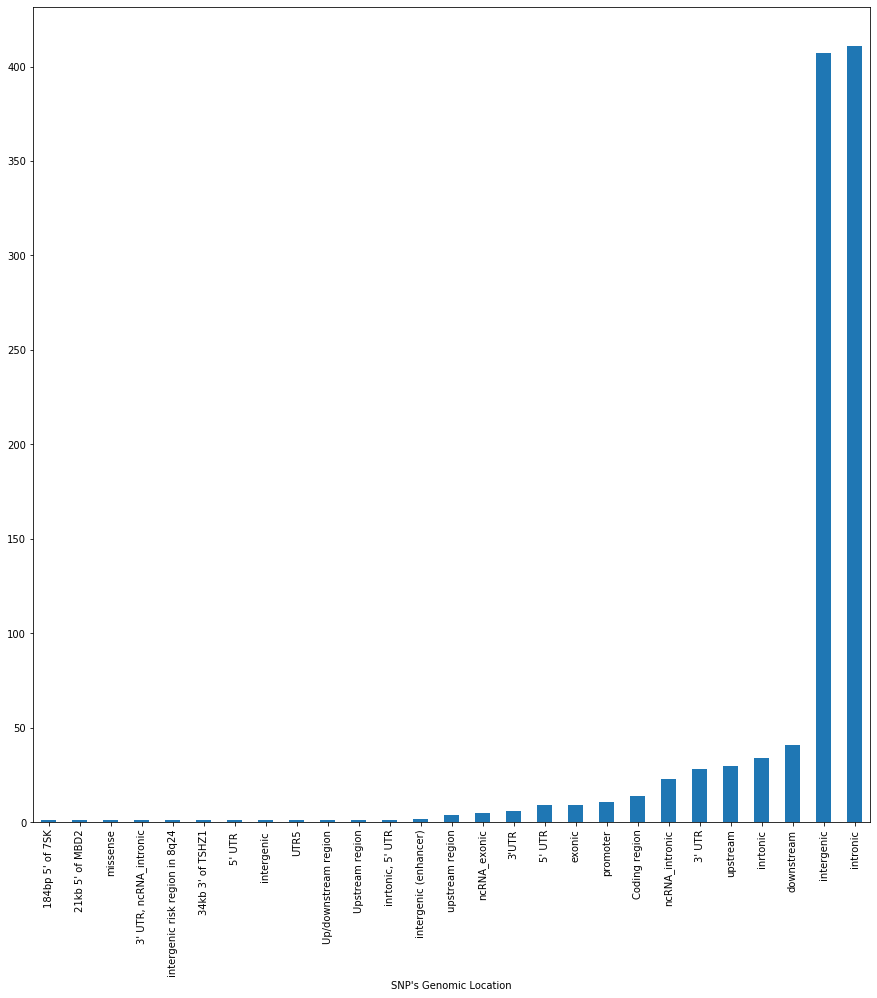

In [52]:
SNP_locations_on_genome = positives.groupby("SNP's Genomic Location")["SNP ID"].nunique().sort_values()
print(SNP_locations_on_genome)
SNP_locations_on_genome.plot.bar(figsize = (15,15))

As can be seen, the overwhelming majority of the SNPs are located on the intronic part of the genome.
However, we also see a small number of SNPs located in the coding reagon and the exons.

The genes targeted by these SNPs are obvious, and not part of our objective.

#### Number of genes targeted by each SNP
Next, we take a look at the number of genes that are targeted by each SNP

Quantiles


0.25    1
0.50    1
0.75    2
1.00    6
Name: gene, dtype: int64

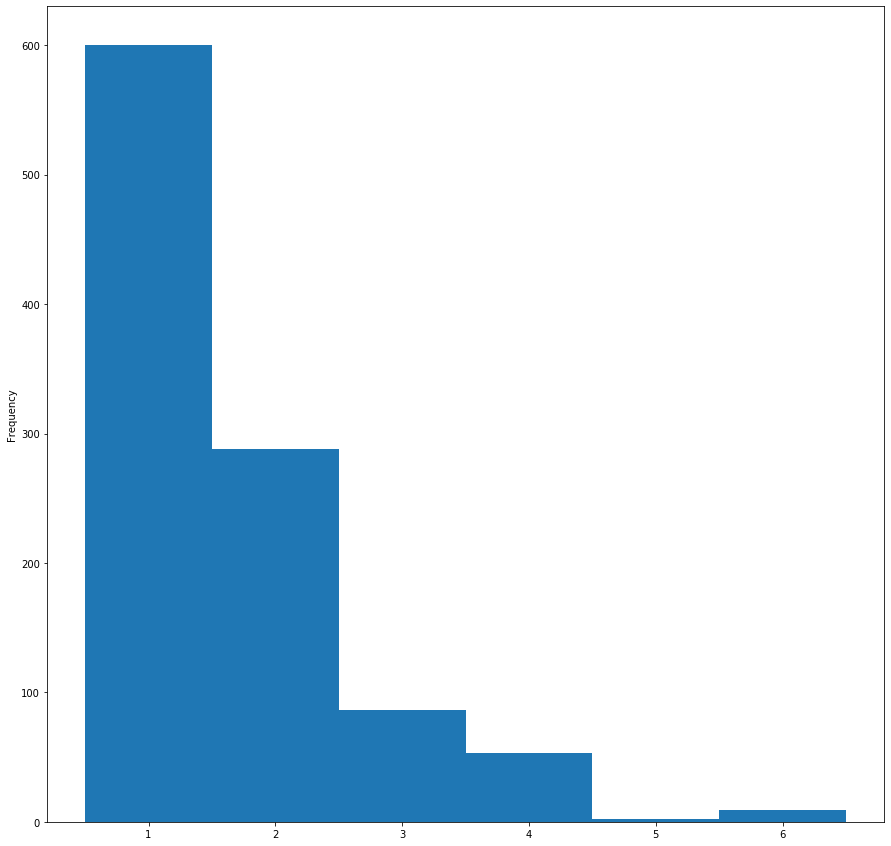

In [140]:
genes_per_snp = positives.groupby("SNP ID")["gene"].nunique()
genes_per_snp.plot.hist(figsize = (15,15), align = "left", bins = range(1,8))
print("Quantiles")
genes_per_snp.quantile(q = [0.25, 0.5, 0.75, 1]).astype(int)

SNPs overwhelmingly target only one or two genes, which appears to be in line with what we know from literature.

#### Number of SNPs targeting a each gene
Next, we take a look at the number of SNPs targeting each gene.

Quantiles


0.25    1.0  
0.50    1.0  
0.75    3.0  
1.00    149.0
Name: SNP ID, dtype: float64

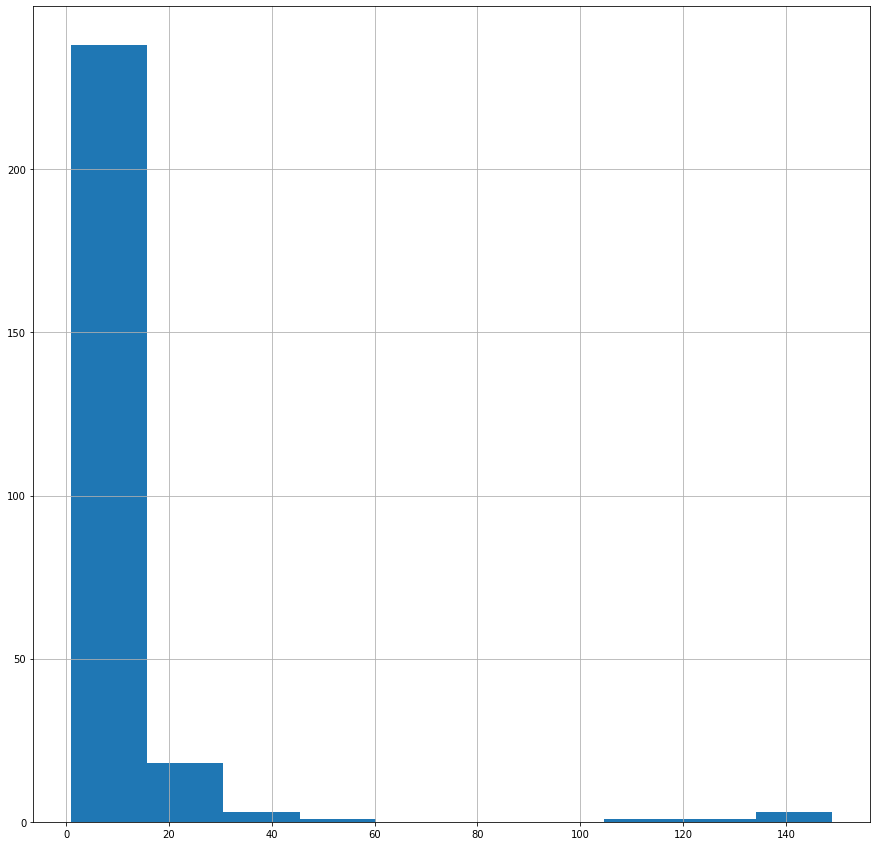

In [58]:
snps_per_gene = positives.groupby("gene")["SNP ID"].nunique()
snps_per_gene.hist(figsize = (15,15))
print("Quantiles")
snps_per_gene.quantile(q = [0.25, 0.5, 0.75, 1])

Here we see an enormously skewed distribution, with at its maximum 149 SNPs targeting a single gene.

We therefore group the results by both their studies and experimental methods, to investigate what causes this skewed distribution.

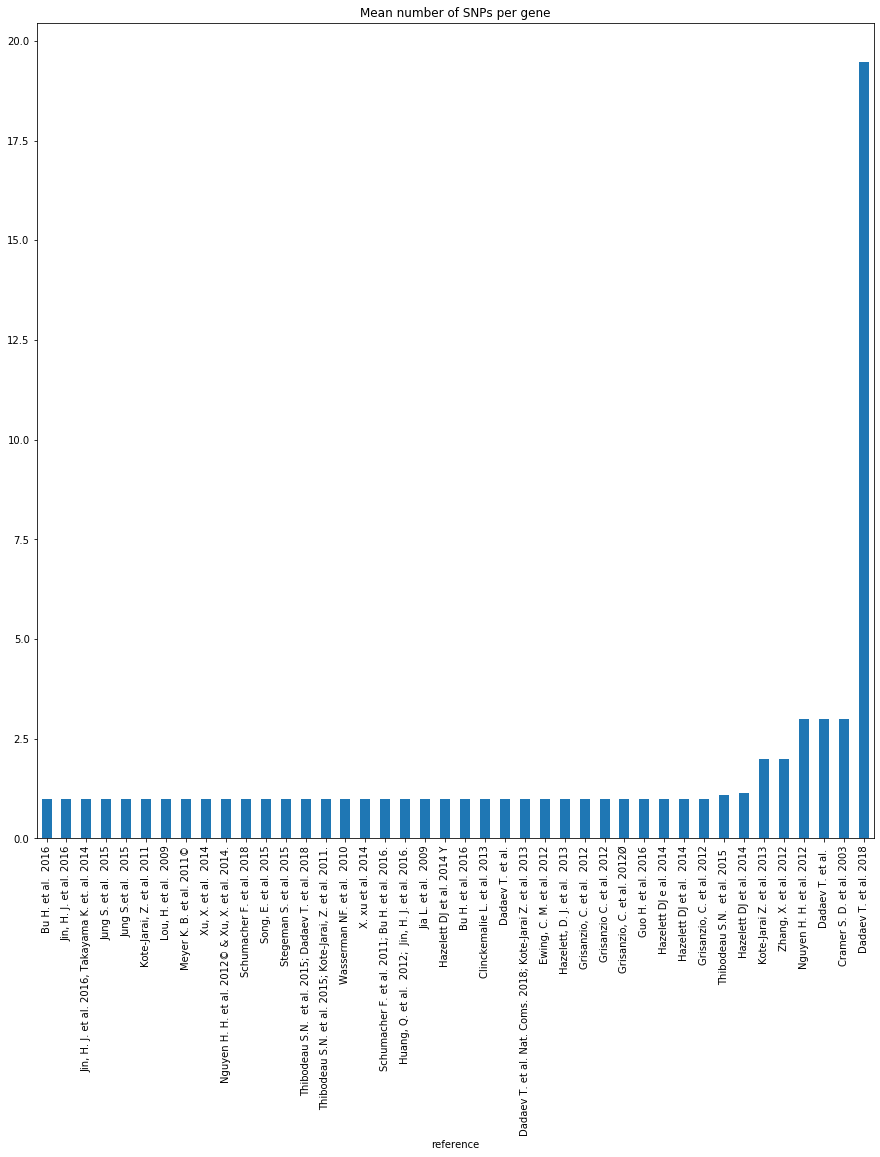

In [106]:
# Reference based
ref = positives.groupby(["reference", "gene"])["SNP ID"].nunique()
ref.mean(level = 0).sort_values().plot.bar(figsize = (15, 15), title = "Mean number of SNPs per gene based on reference")

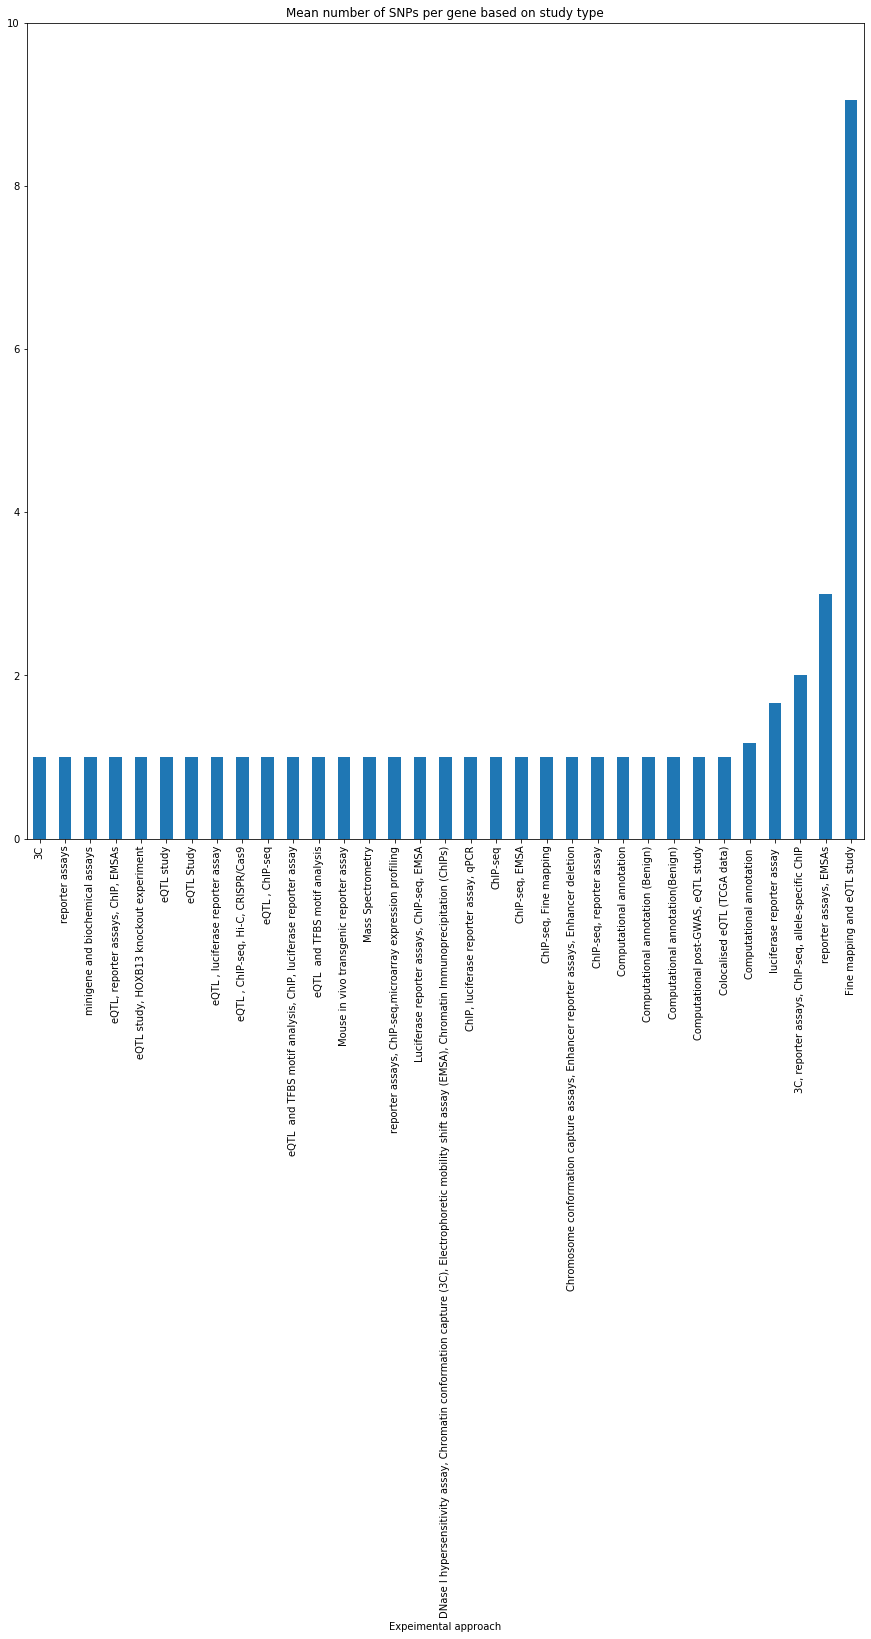

In [113]:
# Method based
method = positives.groupby(["Expeimental approach", "gene"])["SNP ID"].nunique()
method.mean(level = 0).sort_values().plot.bar(figsize = (15, 15), title = "Mean number of SNPs per gene based on study type", ylim = (0,10))

Based on the figures above, it appears that both the study of Dadaev as well as the Fine mapping and eQTL study method are outliers in the number of SNPs that target each gene.
However, these data are not independent from each other, as Dadaev's study design was based on Fine mapping and eQTL study.
Furthermore, because the mean of Dadaev's study is higher than the one of the experimental method, it is likely that Dadaev's study skews the mean of the Fine mapping and eQTL study, rather than the other way around.

Therefore, we investigate what happens to the number of SNPs targeting each gene when we exclude Dadaev's study from the reference set.

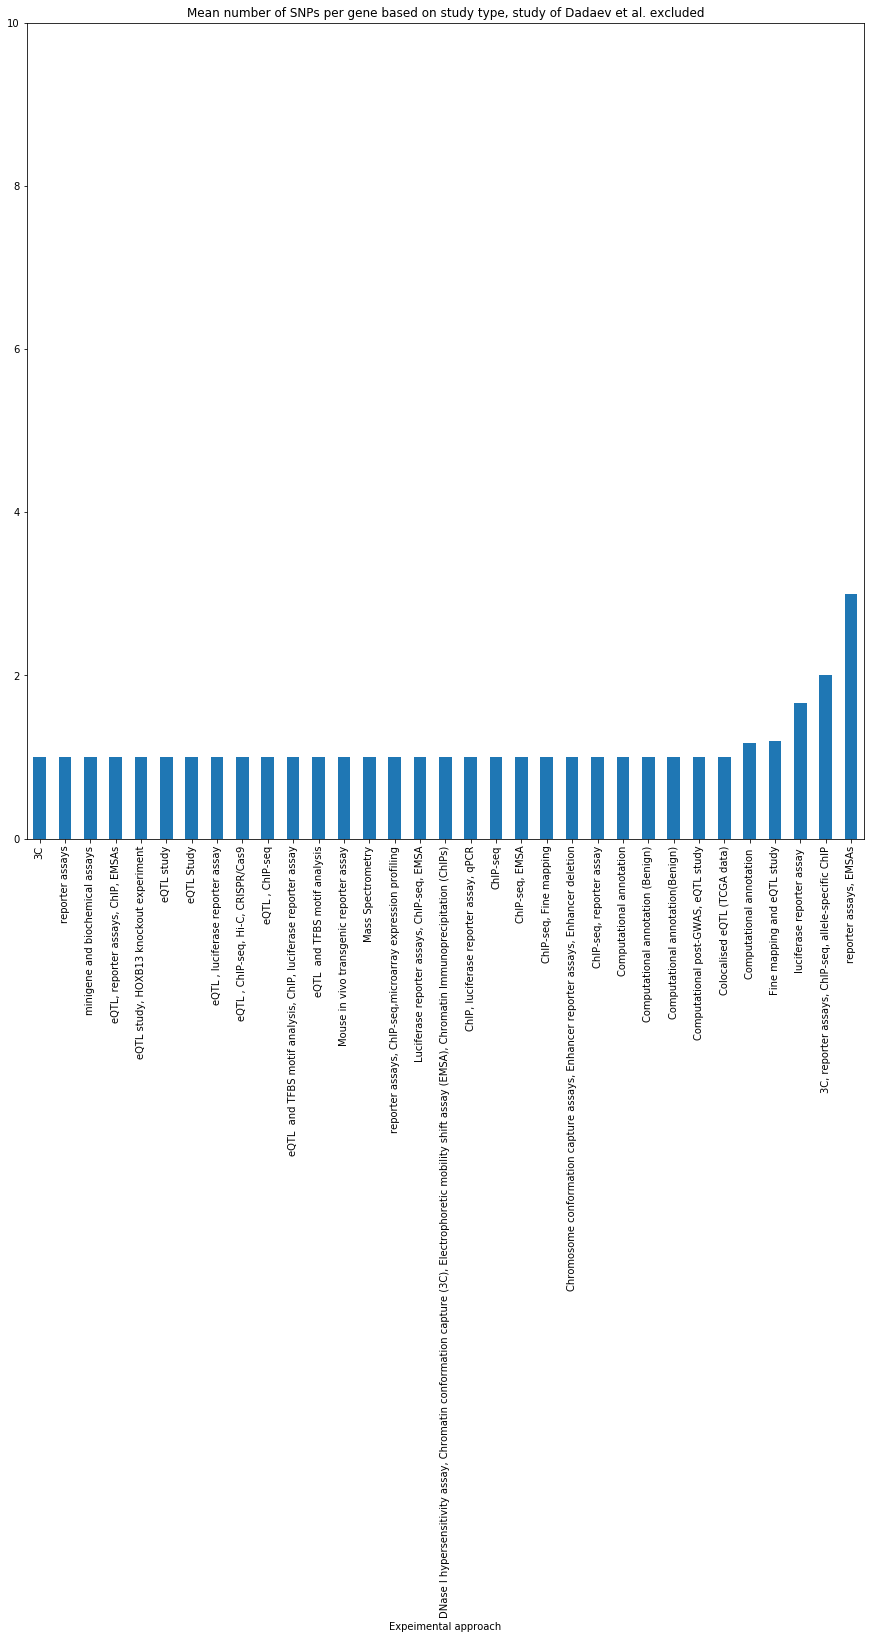

In [115]:
#TODO: Kijken of de studies van Dadaev hetzelfde artikel zijn

no_dadaev = positives[~positives["reference"].isin(["Dadaev T. et al. 2018", "Dadaev T. et al."])].groupby(["Expeimental approach", "gene"])["SNP ID"].nunique()
no_dadaev.mean(level = 0).sort_values().plot.bar(figsize = (15, 15), title = "Mean number of SNPs per gene based on study type, study of Dadaev et al. excluded", ylim = (0,10))

With the study of Dadaev excluded, the Fine mappign and eQTL study method is no longer an outlier in the number of SNPs that target each gene.

#### Filtering the reference set
Based on the findingds above, we can define two filters:

1. We remove all entries that are found on the coding part of the genome
2. We remove all entries that were based upon the study by Dadaev

In [142]:
# Remove entries that are based on a single eQTL study, or that are found in the exon/coding region
Dadaev = ["Dadaev T. et al. 2018", "Dadaev T. et al."]
coding_snps = ["Coding region", "exonic"]

positives = positives[(~positives["reference"].isin(Dadaev)) & (~positives["SNP's Genomic Location"].isin(coding_snps))]

### Properties of the modified reference set

We now describe the properties of the modified reference set, and investigate whether we can map it to the nodes in PathwayStudio.

In [143]:
# Map the genes to their node identifiers
nodes = session.run("Match (n) WHERE n.name IN " + str(list(set(farashi["gene"]))) + " RETURN n").value()
# Validate the mappings
known_unmappable_genes = {"MFSD4A-AS1", "NCR00171"}
print("Mapping succesful, only known genes MFSD4A-AS1 and NCR00171 unsuccesfully mapped") if set(farashi["gene"]) - set([x["name"] for x in nodes]) == known_umappable_genes else print("Mapping incomplete")

Mapping succesful, only known genes MFSD4A-AS1 and NCR00171 unsuccesfully mapped


## Gene expression data

Now that we have our reference set, we obtain the gene-expression data.
This data is obtained from a separate Next-Generation sequencing dataset, which compared the expression of men with prostate cancer, to that of men without prostate cancer.

In [12]:
# Extract the gene expression data
cols = pd.read_csv("Input sets/Gene expression data/design_matrix_prostate_unpaired.txt", delimiter = "\t")
reads = pd.read_csv("Input sets/Gene expression data/expression_matrix_prostate_clean.txt", delimiter = "\t")
# Read in the differential expression calculations
dex = pd.read_csv("Input sets/Gene expression data/Galaxy37-[edgeR_DGE_on_2__design_matrix_prostate_unpaired.txt_-_differentially_expressed_genes].tabular.annotated.txt", 
                  delimiter = "\t", index_col = 0, names = ["ENSEMBL", "gene", "logFC", "logCPM", "LR", "pValue", "FDR"], header = 0)
dex["ENSEMBL"].replace("(\.\d+)", "", regex = True, inplace = True)

reads["total"] = reads.sum(axis = 1, numeric_only = True)
reads["freq"] = ((reads[list(cols["samplename"])] > 0) * 1).sum(axis = 1)
reads["gene_ids"].replace("(\.\d+)", "", regex = True, inplace = True)

reads = reads.merge(dex, left_on = "gene_ids", right_on = "ENSEMBL", how = "outer")

In [13]:
# Initiate the connection to the database (first time you may have to run ensembl.download() and ensembl.index() first)
# To align with our reference set, we take a Ensembl version from 2019
from pyensembl import EnsemblRelease
ensembl = EnsemblRelease(92)

# Function to extract the data (and prevent superfluous queries)
def getEnsemblData(id):
    try:
        data = ensembl.gene_by_id(id)
        return pd.Series({"gene_name" : data.gene_name, 
                          "chromosome" : data.contig, 
                          "start" : data.start,
                          "stop" : data.end,
                          "protein_coding" : data.is_protein_coding})
    except ValueError:
        return pd.Series({"gene_name" : None, 
                          "chromosome" : None, 
                          "start" : None,
                          "stop" : None,
                          "protein_coding" : None})

# Remove the postifxes of the gene identifiers
reads["gene_ids"].replace("\.\d", "", regex = True, inplace = True)
reads[["gene_name", "chromosome", "start", "stop", "protein_coding"]] = reads["gene_ids"].apply(lambda x: getEnsemblData(x))

# Drop the mitochondrial genes and the entries that could not be found
reads.drop(reads[reads["chromosome"].isin(["MT", None])].index, inplace = True)

In [14]:
# Create a dataframe of all combinations of SNPs and genes that are on the same chromosome
positives["location"] = positives["location"].astype(int)
snp_candidates = positives[["SNP ID", "chromosome", "location"]].merge(reads[["gene_ids", "gene_name", "chromosome", "start", "stop"]], on = "chromosome", how = "inner")

# Select the pairs where the SNP window and the gene windows overlap
snp_candidates["candidate"] = snp_candidates.apply(lambda x: True if ((x["stop"] >= x["location"] - delta_bp and x["stop"] <= x["location"] + delta_bp) or 
                                                                      (x["start"] >= x["location"] - delta_bp and x["start"] <= x["location"] + delta_bp)) else False, axis = 1)
snp_candidates.drop(snp_candidates[snp_candidates["candidate"] == False].index, inplace = True)

In [16]:
# Split up the dataset into cancer and non-cancer samples
cancer = reads[["gene_ids"] + list(cols.samplename[cols.condition == "cancer"])].copy()
normal = reads[["gene_ids"] + list(cols.samplename[cols.condition == "normal"])].copy()

In [17]:
# Check whether all genes in the reference set are in the expression data
len(set(farashi["Target/assigned/e-Gene"]) - set(reads["gene_name"]))

In [18]:
# Calculate the fold change and p-values

## Query all the incoming and outgoing pathway data for the genes

In [62]:
# Get the incoming and outgoing paths of the genes
direct = pd.DataFrame(session.run("Match p = (n)-[r]-(x:Protein)" +
                                  " WHERE n.name IN " + str(list(farashi["Target/assigned/e-Gene"])) + 
                                  " RETURN startnode(r).name AS start," +
                                  " type(r) AS relationship," + 
                                  " r.pmid AS pmid," +
                                  " length(r.pmid) AS npmid," + 
                                  " endnode(r).name AS end").data())

In [63]:
# Get the indirect outgoing paths
outgoing = pd.DataFrame(session.run("Match p = (n)-[r]->(x:Protein)-[r2]->(y:Protein)" +
                                    " WHERE n.name IN " + str(list(set(farashi["Target/assigned/e-Gene"]))) +
                                    " RETURN startnode(r).name AS start," +
                                    " type(r) AS relationship1," +
                                    " r.pmid AS pmid1," +
                                    " length(r.pmid) AS npmid1," +
                                    " endnode(r).name AS middle," +
                                    " type(r2) AS relationship2," +
                                    " r2.pmid AS pmid2," +
                                    " length(r2.pmid) AS npmid2," +
                                    " endnode(r2).name AS end").data())

In [64]:
# Get the indirect incoming paths
incoming = pd.DataFrame(session.run("Match p = (x:Protein)-[r]->(y:Protein)-[r2]->(n)"
                                    " WHERE n.name IN " + str(list(set(farashi["Target/assigned/e-Gene"]))) +
                                    " RETURN startnode(r).name AS start," +
                                    " type(r) AS relationship1," +
                                    " r.pmid AS pmid1," +
                                    " length(r.pmid) AS npmid1," +
                                    " endnode(r).name AS middle," +
                                    " type(r2) AS relationship2," +
                                    " r2.pmid AS pmid2," +
                                    " length(r2.pmid) AS npmid2," +
                                    " endnode(r2).name AS end").data())

In [65]:
# Create features based on paths

In [ ]:
## Get shapes
# Triangles query
# Not exists clauses toevoegen
# nodes laten returnen om unieke combinaties te filteren
triangles = "Match p = (n)--(i:Protein)--(i2:Protein)--(n) WHERE n.name = '" + 'KLRK1' + "' RETURN nodes(p)"
#squares = "Match p = (n)--(i:Protein)--(i2:Protein)--(i3:Protein)--(n) WHERE n.name = '" +  + "' RETURN COUNT(p)"
#diagonalSquares = "Match p = (n)-[r]-(i:Protein)-[r2]-(i2:Protein)-[r3]-(i3:Protein)-[r4]-(n)-[r5]-(i2:Protein) WHERE n.name = '" +  + "' RETURN COUNT(p)"
#diagonalSquares2 = "Match p = (i3:Protein)-[r5]-(n)-[r]-(i:Protein)-[r2]-(i2:Protein)-[r3]-(i3:Protein)-[r4]-(i:Protein) WHERE n.name = '" +  + "' RETURN COUNT(p)"

test = session.run(triangles)

In [ ]:
# Calculate network statistics such as eigenvector centrality 
# TODO: Alleen genen nemen die tot expressie komen, en alle relaties includeren
eigenvector = "CALL gds.alpha.eigenvector.stream({" +
              " nodeProjection: 'Protein'," +
              " relationshipProjection: 'Regulation'" +
              "})" + 
              " YIELD nodeId, score" + 
              " RETURN gds.util.asNode(nodeId).name AS page, score" + 
              " ORDER BY score DESC"

degree = "CALL gds.alpha.degree.stream({" +
              " nodeProjection: 'Protein'," +
              " relationshipProjection: 'Regulation'" +
              "})" + 
              " YIELD nodeId, score" + 
              " RETURN gds.util.asNode(nodeId).name AS page, score" + 
              " ORDER BY score DESC"

## Query pathway studio for information about Prostate cancer and it's associated pathways, and use it to filter the pathway information

In [11]:
bla = session.run("MATCH (n:Disease) RETURN n.name ORDER BY n.name DESC")

In [15]:
import re

r = re.compile("^prostate.*")
list(filter(r.match, out))

['prostate neoplasm', 'prostate carcinoma', 'prostate cancer']

In [23]:
# Extract the disease nodes for prostate cancer
pca_names = ['prostate neoplasm',
             'prostate carcinoma',
             'prostate cancer']

pca = session.run("MATCH (n:Disease) WHERE n.name IN " + str(pca_names) + " RETURN n.name, id(n)").data()
pca = dict(zip([x["n.name"] for x in pca], [x["id(n)"] for x in pca]))

In [43]:
# Find relationships between the disease nodes --> pathways --> genes
test = session.run("MATCH (n)-[r]->(path:Pathway)<-[r2]-(prot:Protein) WHERE id(n) IN " + str(list(pca.values())) + " RETURN path.name AS pathway, prot.name AS gene").data()

test2 = session.run("MATCH (n)-[r]->(prot:Protein) WHERE id(n) IN " + str(list(pca.values())) + " RETURN type(r) AS relationship, r.pmid AS pmid, prot.name AS gene").data()

# Building a classifier

In [ ]:
from sklearn import datasets
iris = datasets.load_iris()

In [ ]:
from sklearn.model_selection import train_test_split

data=pd.DataFrame({
    'sepal length':iris.data[:,0],
    'sepal width':iris.data[:,1],
    'petal length':iris.data[:,2],
    'petal width':iris.data[:,3],
    'species':iris.target
})

X=data[['sepal length', 'sepal width', 'petal length', 'petal width']]  # Features
y=data['species']  # Labels

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

from sklearn.ensemble import RandomForestClassifier

#Create a Gaussian Classifier
clf=RandomForestClassifier(n_estimators=100)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train,y_train)

y_pred=clf.predict(X_test)


from sklearn import metrics
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

from sklearn.model_selection import cross_validate
scores = cross_validate(clf, X, y, scoring = ['precision_macro', 'recall_macro'], cv = 10, n_jobs = -1)